In [7]:
#make full cpg-genome annotation
import pandas as pd
import pyranges as pr
import gzip

# Load CpG methylation data
df_cpgs = pd.read_csv("/data/cephfs-1/work/groups/kühnen/users/cama15_c/meth_matrix_files/meth_matrix_10_samples.csv", sep=",")
df_cpgs = df_cpgs.rename(columns={"Chr": "Chromosome"})
df_base = df_cpgs.copy(deep=True)

# Ensure proper types
df_base["Chromosome"] = df_base["Chromosome"].astype(str)
df_base["Start"] = df_base["Start"].astype(int)
df_base["End"] = df_base["End"].astype(int)

# Create PyRanges object
gr_cpgs = pr.PyRanges(df_base[["Chromosome", "Start", "End"]])

# 1. Annotate overlaps with BED features
bed_files = {
    "TSS": "gencode_v48_TSSs.bed",
    "Promoter": "gencode_v48_promoters.bed",
    "GeneBody": "gencode_v48_gene_bodies.bed",
    "Exon": "gencode_v48_exons.bed",
    "Intron": "gencode_v48_introns.bed"
}

for feature_name, bed_file in bed_files.items():
    gr_feature = pr.read_bed(bed_file)

    # Expand ±1000 bp for TSS
    if feature_name == "TSS":
        df_feat = gr_feature.df.copy()
        df_feat["Start"] = df_feat["Start"] - 1000
        df_feat["End"] = df_feat["End"] + 1000
        gr_feature = pr.PyRanges(df_feat)

    overlaps_df = gr_cpgs.count_overlaps(gr_feature).df
    overlaps_df = overlaps_df[["Chromosome", "Start", "End", "NumberOverlaps"]].drop_duplicates()
    overlaps_df[f"Overlaps_{feature_name}"] = overlaps_df["NumberOverlaps"] > 0

    df_base = df_base.merge(overlaps_df.drop(columns="NumberOverlaps"),
                            on=["Chromosome", "Start", "End"], how="left")
    df_base[f"Overlaps_{feature_name}"] = df_base[f"Overlaps_{feature_name}"].fillna(False)

# 2. Annotate GeneBody_Type from GTF
gtf_file = "gencode.v48.basic.annotation.gtf.gz"
gtf_cols = ["Chromosome", "Source", "Feature", "Start", "End", "Score", "Strand", "Frame", "Attributes"]

with gzip.open(gtf_file, "rt") as f:
    gtf = pd.read_csv(f, sep="\t", comment="#", names=gtf_cols)

genes = gtf[gtf["Feature"] == "gene"].copy()
genes["gene_type"] = genes["Attributes"].str.extract(r'gene_type "([^"]+)"')
genes["gene_id"] = genes["Attributes"].str.extract(r'gene_id "([^"]+)"')

target_types = ["protein_coding", "lncRNA", "pseudogene", "miRNA"]
genes_filtered = genes[genes["gene_type"].isin(target_types)].copy()

gr_genes_filtered = pr.PyRanges(genes_filtered[["Chromosome", "Start", "End", "gene_type", "gene_id"]])
gr_gene_overlap = gr_cpgs.join(gr_genes_filtered)

overlap_df = gr_gene_overlap.df[["Chromosome", "Start", "End", "gene_type"]].drop_duplicates()
overlap_df.rename(columns={"gene_type": "GeneBody_Type"}, inplace=True)

df_base = df_base.merge(overlap_df, on=["Chromosome", "Start", "End"], how="left")
df_base["GeneBody_Type"] = df_base["GeneBody_Type"].fillna("None")

# 3. Annotate proximity to repeat elements
rmsk_file = "rmsk.txt.gz"
rmsk_cols = ["bin", "swScore", "milliDiv", "milliDel", "milliIns",
             "genoName", "genoStart", "genoEnd", "genoLeft",
             "strand", "repName", "repClass", "repFamily",
             "repStart", "repEnd", "repLeft", "id"]

rmsk = pd.read_csv(rmsk_file, sep="\t", names=rmsk_cols, header=None, compression='gzip')

repeat_types = {
    "Alu": rmsk[rmsk["repName"].str.contains("Alu")],
    "L1": rmsk[rmsk["repName"].str.contains("L1")],
    "SVA": rmsk[rmsk["repName"].str.contains("SVA")],
    "MIR": rmsk[rmsk["repName"].str.contains("MIR")],
    "LTR": rmsk[rmsk["repClass"].str.contains("LTR")]
}

for rep_type, df_rep in repeat_types.items():
    df_rep_rename = df_rep.rename(columns={"genoName": "Chromosome",
                                           "genoStart": "Start",
                                           "genoEnd": "End"})
    gr_rep = pr.PyRanges(df_rep_rename[["Chromosome", "Start", "End"]])

    nearest = gr_cpgs.nearest(gr_rep)
    df_dist = nearest.df[["Chromosome", "Start", "End", "Distance"]].drop_duplicates()
    df_dist = df_dist.rename(columns={"Distance": f"Dist_to_{rep_type}"})

    df_base = df_base.merge(df_dist, on=["Chromosome", "Start", "End"], how="left")
    df_base[f"Dist_to_{rep_type}"] = df_base[f"Dist_to_{rep_type}"].fillna(10**9)
    df_base[f"Near_{rep_type}"] = df_base[f"Dist_to_{rep_type}"] <= 1000

# Save final output
df_base.to_csv("full_genome_cpgs_annotated.csv", index=False)
print("Annotation complete. File saved as 'full_genome_cpgs_annotated.csv'")


Annotation complete. File saved as 'full_genome_cpgs_annotated.csv'


In [9]:
print(df_base.columns)

Index(['Chromosome', 'Start', 'End', 'Naive_1_frac', 'Naive_1_cov',
       'Formative_1_frac', 'Formative_1_cov', 'Primed_1_frac', 'Primed_1_cov',
       'Formative_Neuron_1_frac', 'Formative_Neuron_1_cov',
       'Primed_Neuron_1_frac', 'Primed_Neuron_1_cov', 'Naive_2_frac',
       'Naive_2_cov', 'Formative_2_frac', 'Formative_2_cov', 'Primed_2_frac',
       'Primed_2_cov', 'Formative_Neuron_2_frac', 'Formative_Neuron_2_cov',
       'Primed_Neuron_2_frac', 'Primed_Neuron_2_cov', 'Overlaps_TSS',
       'Overlaps_Promoter', 'Overlaps_GeneBody', 'Overlaps_Exon',
       'Overlaps_Intron', 'GeneBody_Type', 'Dist_to_Alu', 'Near_Alu',
       'Dist_to_L1', 'Near_L1', 'Dist_to_SVA', 'Near_SVA', 'Dist_to_MIR',
       'Near_MIR', 'Dist_to_LTR', 'Near_LTR'],
      dtype='object')


In [10]:
from scipy.stats import fisher_exact

# === CONFIGURATION ===
CLUSTER_FILE = "annotated_mes_kessler_clusters.csv"
GENOME_FILE = "full_genome_cpgs_annotated.csv"
OUTPUT_FILE = "me_cluster_feature_enrichment_scores.csv"

# === LOAD DATA ===
cluster_df = pd.read_csv(CLUSTER_FILE)
full_df = pd.read_csv(GENOME_FILE)

# Drop methylation fraction and coverage columns
cluster_df = cluster_df.loc[:, ~cluster_df.columns.str.contains("_frac|_cov")]
full_df = full_df.loc[:, ~full_df.columns.str.contains("_frac|_cov")]

# Identify features: Near_* and Overlaps_* boolean columns
feature_cols = [col for col in cluster_df.columns if col.startswith("Near_") or col.startswith("Overlaps_")]

# Build a fast lookup set of cluster CpG positions
results = []

for cluster_id in sorted(cluster_df["Cluster"].unique()):
    cluster_subset = cluster_df[cluster_df["Cluster"] == cluster_id]
    cluster_sites = set(zip(cluster_subset["Chromosome"], cluster_subset["Start"], cluster_subset["End"]))

    # Create indicator column in the full genome: is this CpG in the cluster?
    full_df["in_cluster"] = full_df.apply(
        lambda row: (row["Chromosome"], row["Start"], row["End"]) in cluster_sites,
        axis=1
    )

    for feature in feature_cols:
        # Build contingency table
        in_cluster_true = full_df[(full_df["in_cluster"]) & (full_df[feature] == True)].shape[0]
        in_cluster_false = full_df[(full_df["in_cluster"]) & (full_df[feature] == False)].shape[0]
        not_cluster_true = full_df[(~full_df["in_cluster"]) & (full_df[feature] == True)].shape[0]
        not_cluster_false = full_df[(~full_df["in_cluster"]) & (full_df[feature] == False)].shape[0]

        contingency = [[in_cluster_true, in_cluster_false], [not_cluster_true, not_cluster_false]]

        try:
            odds_ratio, p_value = fisher_exact(contingency)
        except ValueError:
            odds_ratio, p_value = float('nan'), float('nan')

        results.append({
            "Cluster": cluster_id,
            "Feature": feature,
            "In_Cluster_True": in_cluster_true,
            "In_Cluster_False": in_cluster_false,
            "Not_Cluster_True": not_cluster_true,
            "Not_Cluster_False": not_cluster_false,
            "Odds_Ratio": odds_ratio,
            "Fisher_p": p_value
        })

# Convert to DataFrame and sort
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(["Cluster", "Fisher_p"])

# Save to CSV
results_df.to_csv(OUTPUT_FILE, index=False)

print(f"Enrichment results saved to: {OUTPUT_FILE}")

/tmp/ipykernel_3276502/2048686352.py:10: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  full_df = pd.read_csv(GENOME_FILE)


Enrichment results saved to: me_cluster_feature_enrichment_scores.csv


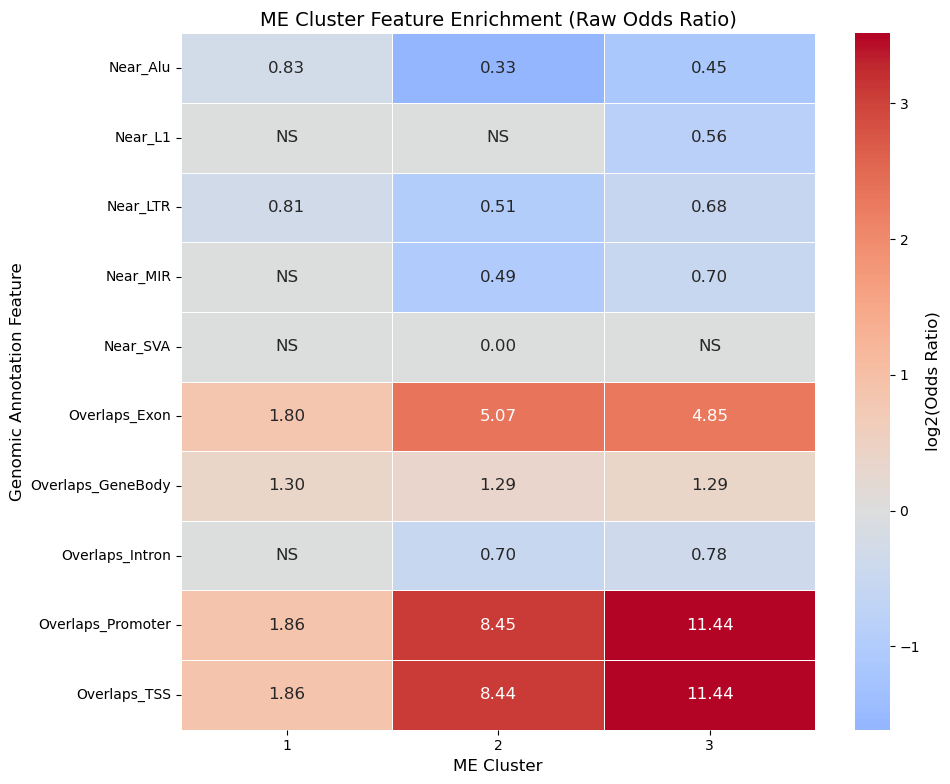

In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load your enrichment result table
df = pd.read_csv("me_cluster_feature_enrichment_scores.csv")

# Convert to pivot format: rows = Feature, columns = Cluster
pivot_or = df.pivot(index="Feature", columns="Cluster", values="Odds_Ratio")
pivot_p = df.pivot(index="Feature", columns="Cluster", values="Fisher_p")

# Log-transform the values for heatmap color
log_or = np.log2(pivot_or.replace(0, np.nan))  # Avoid -inf for 0
log_or_masked = log_or.where(pivot_p <= 0.001)

# Fill NaNs in log_or_masked to plot with neutral color (e.g. 0)
plot_data = log_or_masked.fillna(0)

# Create annotation matrix using raw OR for significant values, else 'NS'
annot_matrix = pivot_or.copy().astype(object)
for row in annot_matrix.index:
    for col in annot_matrix.columns:
        if pivot_p.loc[row, col] <= 0.001:
            or_val = pivot_or.loc[row, col]
            annot_matrix.loc[row, col] = f"{or_val:.2f}"
        else:
            annot_matrix.loc[row, col] = "NS"

# Plotting style
plt.rcParams.update({ 
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

# Plot heatmap with annotations
plt.figure(figsize=(10, 8))
sns.heatmap(
    plot_data, 
    annot=annot_matrix, 
    fmt='',
    cmap="coolwarm", 
    center=0,
    linewidths=0.5, 
    cbar_kws={'label': 'log2(Odds Ratio)'}
)
plt.title("ME Cluster Feature Enrichment (Raw Odds Ratio)")
plt.ylabel("Genomic Annotation Feature")
plt.xlabel("ME Cluster")
plt.tight_layout()

plt.savefig("me_cluster_enrichment_heatmap.pdf", bbox_inches='tight')
plt.savefig("me_cluster_enrichment_heatmap.svg", bbox_inches='tight')
plt.show()